In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import PIL.Image as Image

from tensorflow.keras import layers

tf.__version__

'2.1.0'

In [2]:
CLASSIFIER_URL = "https://tfhub.dev/google/imagenet/inception_v3/classification/4"
IMAGE_SHAPE = (299, 299)

classifier = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL)
])

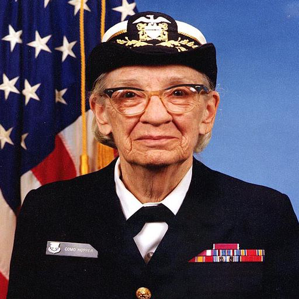

In [3]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [4]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper = grace_hopper[np.newaxis, ...]
grace_hopper.shape

(1, 299, 299, 3)

In [5]:
result = classifier.predict(grace_hopper)
result.shape

(1, 1001)

In [6]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [7]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [8]:
imagenet_labels[:10]

array(['background', 'tench', 'goldfish', 'great white shark',
       'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock',
       'hen'], dtype='<U30')

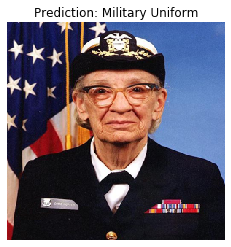

In [9]:
plt.imshow(grace_hopper[0])
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title("Prediction: " + predicted_class_name.title());

In [10]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [12]:
image_batch, label_batch = next(iter(image_data))
print("Image batch shape: ", image_batch.shape)
print("Label batch shape: ", label_batch.shape)

Image batch shape:  (32, 299, 299, 3)
Label batch shape:  (32, 5)


In [13]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [14]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'rapeseed', 'bikini', 'rapeseed', 'daisy', 'daisy',
       'hair slide', 'rapeseed', 'cardoon', 'daisy', 'rapeseed',
       'cardoon', 'bee', 'cardoon', 'bee', 'daisy', 'envelope', 'daisy',
       'pot', 'daisy', 'pot', 'picket fence', 'bee', 'buckeye', 'daisy',
       'daisy', 'bee', 'lionfish', 'daisy', 'head cabbage', 'ballpoint',
       'ringlet'], dtype='<U30')

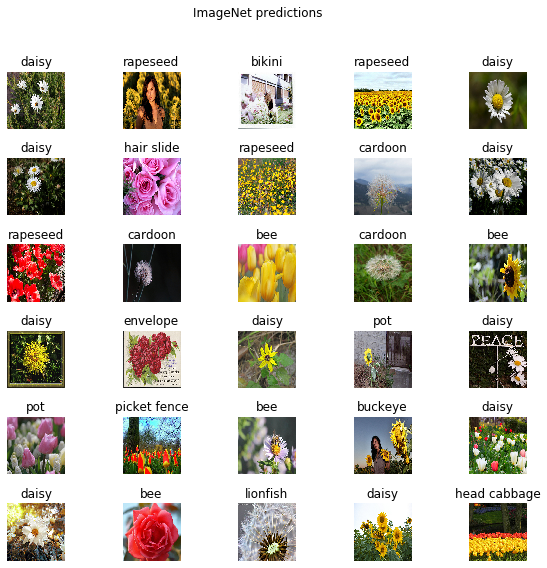

In [15]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [16]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4" 

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(299,299,3))
feature_extractor_layer.trainable = False

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [17]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [19]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=5,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 115.0 steps
Epoch 1/5
115/115 [==============================] - 23s 200ms/step - loss: 0.6366 - acc: 0.6875
Epoch 2/5
115/115 [==============================] - 18s 161ms/step - loss: 0.3467 - acc: 0.9062
Epoch 3/5
115/115 [==============================] - 18s 161ms/step - loss: 0.2759 - acc: 0.9062
Epoch 4/5
115/115 [==============================] - 19s 161ms/step - loss: 0.2338 - acc: 0.9375
Epoch 5/5
115/115 [==============================] - 19s 162ms/step - loss: 0.2113 - acc: 0.8438


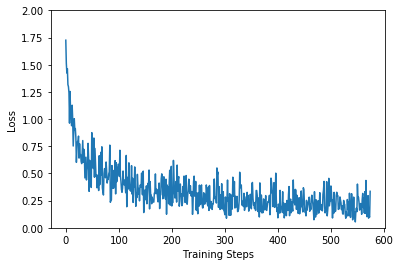

In [20]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

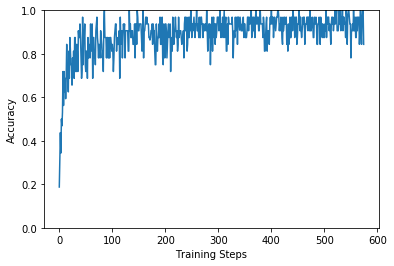

In [21]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [22]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

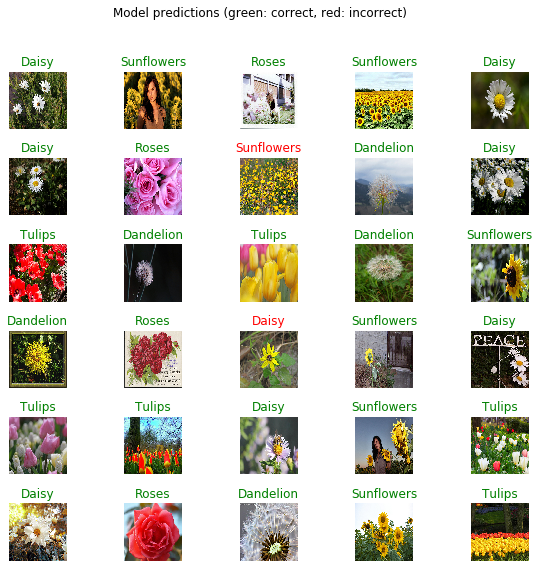

In [23]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")